In [1]:
import sys
sys.path.insert(1, '/t0-analysis/CKA-similarity')

import numpy as np
from CKA import CKA

import matplotlib
import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file

In [2]:
# params
log_dir = "/logfiles"
model = "bigscience-T0_3B" # bigscience-T0_B or bigscience-T0
module = "encoder" # encoder or decoder
task = "rte"
# task = "cb"
# task = "wic"

## Prompts

In [3]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}.csv")
display(df)

,name,template,category,includes_labels,shuffle
0,null_pattern,{premise} {hypothesis},neutral,False,False
1,null_pattern_reversed,{hypothesis} {premise},neutral,False,False
2,gpt_3_yes_no,{premise} Question: {hypothesis} Yes or No?,instructive,True,False
3,gpt_3_true_false,{premise} Question: {hypothesis} True or False?,instructive,True,False
4,mnli_crowdsource,{premise} Using only the above description and...,instructive,True,False
5,based_on_previous_passage,"{premise} Based on the previous passage, is it...",instructive,True,False
6,infer,"Suppose {premise} Can we infer that ""{hypothes...",instructive,True,False
7,follow,Given that {premise} Does it follow that {hypo...,instructive,True,False
8,imply,"{premise} Question: Does this imply that ""{hyp...",instructive,True,False
9,guaranteed,"Given {premise} Is it guaranteed true that ""{h...",instructive,True,False


## Comput CKA per prompt across layers

In [4]:
# RTE patterns
use_pattern = [
    "null_pattern",
    "null_pattern_reversed",
    "gpt_3_yes_no",
    "gpt_3_yes_no_shuffled",
    "gpt_3_true_false",
    "gpt_3_true_false_shuffled",
    "start_with_the",
    "mnli_crowdsource",
    "based_on_previous_passage",
    "infer",
    "follow",
    "imply",
    "guaranteed",
    "justified", 
    "must_be_true",
    "should_assume"
]

# CB patterns
# use_pattern = [
#     "null_pattern",
#     "null_pattern_reversed",
#     "gpt_3_true_false_neither",
#     "gpt_3_yes_no_maybe",
#     "mnli_crowdsource",
#     "always_sometimes_never",
#     "based_on_previous_passage",
#     "infer",
#     "claim",
#     "consider",
#     "follow",
#     "imply",
#     "guaranteed",
#     "guaranteed_possible",
#     "justified",
#     "must_be_true",
#     "should_assume",
#     "take_the_following",
# ]

# WIC patterns
# use_pattern = [
#     "gpt_3",
#     "gpt_3_yes_no",
#     "affirmation",
#     "grammar_homework",
#     "polysemous",
#     "question_context",
#     "question_meaning",
#     "question_meaning_yes_no",
#     "same_sense",
#     "similar_sense",
#     "similar_sense_yes_no",
# ]

In [5]:
representations = {}

for _, row in df.iterrows():
    prompt_name = row['name']
    
    if prompt_name in use_pattern:
        if prompt_name not in representations:
            representations[prompt_name] = {}
        
        for layer in range(0, 25):
            layer_key = f"{module}-{layer}"

            if layer_key not in representations[prompt_name]:
                representations[prompt_name][layer_key] = {}

            file_name = f"{task}/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5"
            
            # load hidden representations from hdf5 file
            representations[prompt_name][layer_key] = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name), silent=True)

In [6]:
representations.keys()

dict_keys(['null_pattern', 'null_pattern_reversed', 'gpt_3_yes_no', 'gpt_3_true_false', 'mnli_crowdsource', 'based_on_previous_passage', 'infer', 'follow', 'imply', 'guaranteed', 'justified', 'must_be_true', 'should_assume', 'start_with_the', 'gpt_3_yes_no_shuffled', 'gpt_3_true_false_shuffled'])

In [8]:
representations["null_pattern"].keys()

dict_keys(['encoder-0', 'encoder-1', 'encoder-2', 'encoder-3', 'encoder-4', 'encoder-5', 'encoder-6', 'encoder-7', 'encoder-8', 'encoder-9', 'encoder-10', 'encoder-11', 'encoder-12', 'encoder-13', 'encoder-14', 'encoder-15', 'encoder-16', 'encoder-17', 'encoder-18', 'encoder-19', 'encoder-20', 'encoder-21', 'encoder-22', 'encoder-23', 'encoder-24'])

In [9]:
representations["null_pattern"]["encoder-0"].shape

(277, 2048)

In [10]:
# Compute CKA for every pattern across layers
np_cka = CKA()

cka_scores_pattern = {}
for pattern in list(representations.keys())[:]:
    cka_scores = []
    for layer1 in representations[pattern].keys():
        cka_scores_layer1 = []
        for layer2 in representations[pattern].keys():
            cka_score = np_cka.linear_CKA(representations[pattern][layer1], representations[pattern][layer2])
            cka_scores_layer1.append(cka_score)
        cka_scores.append(cka_scores_layer1)
    cka_scores = np.asarray(cka_scores)
    cka_scores_pattern[pattern] = cka_scores

In [11]:
cka_scores_pattern['null_pattern'].shape

(25, 25)

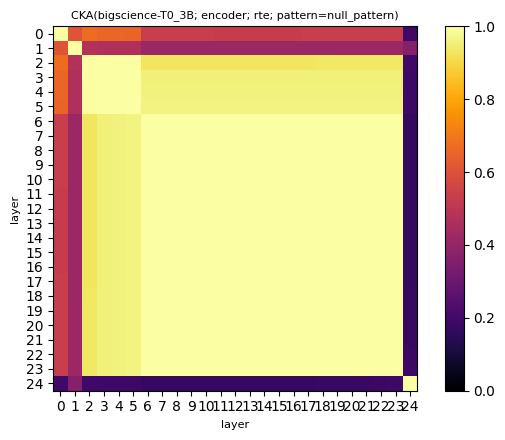

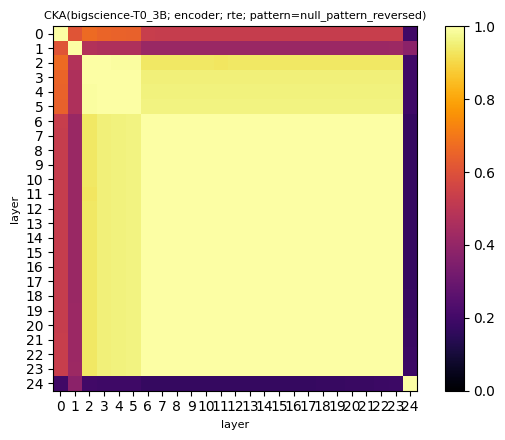

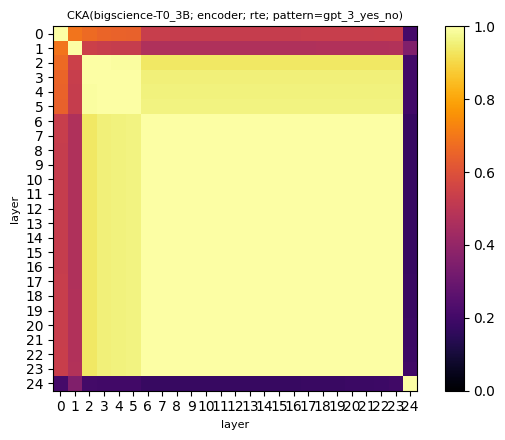

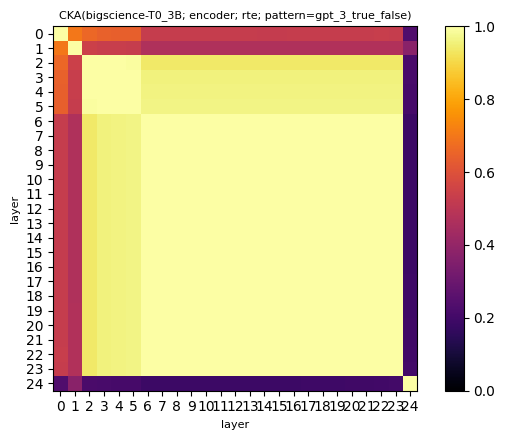

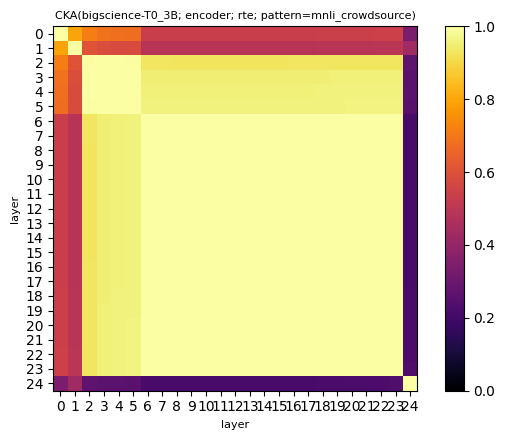

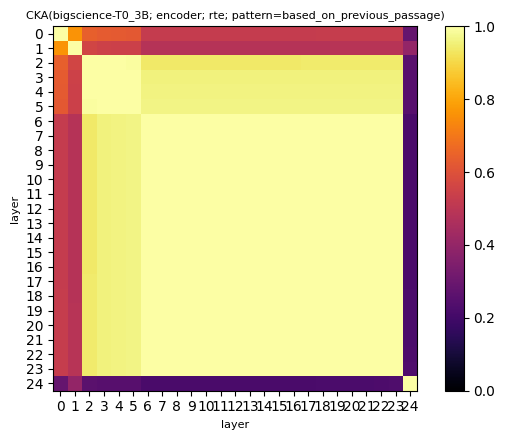

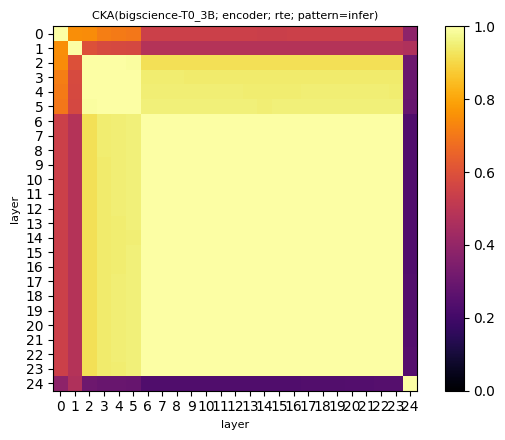

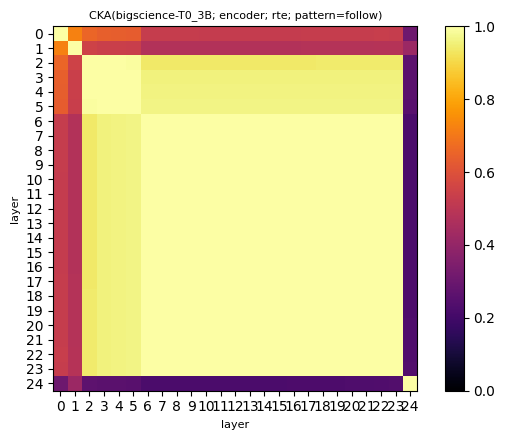

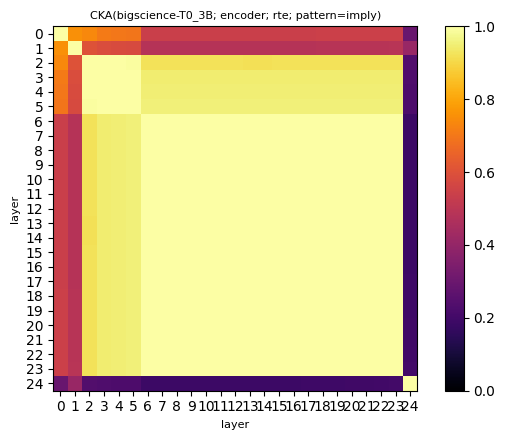

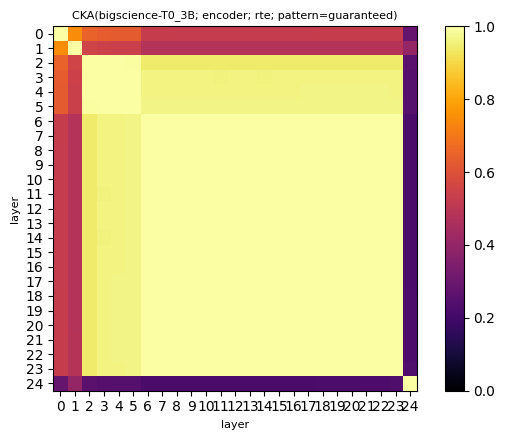

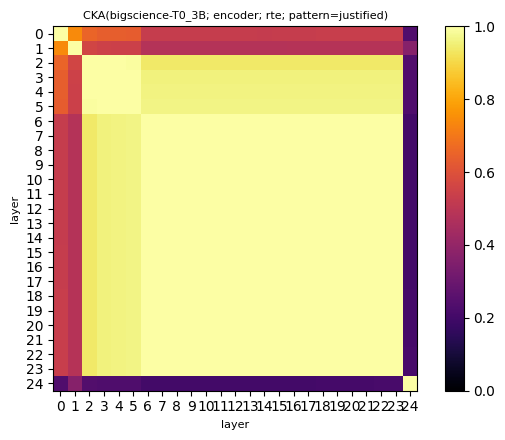

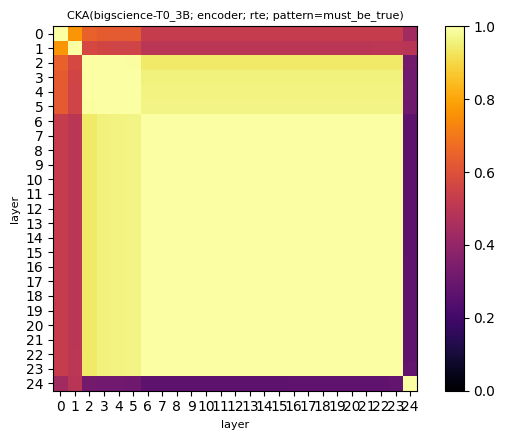

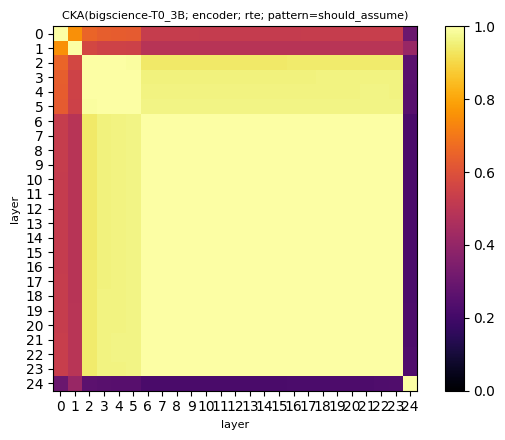

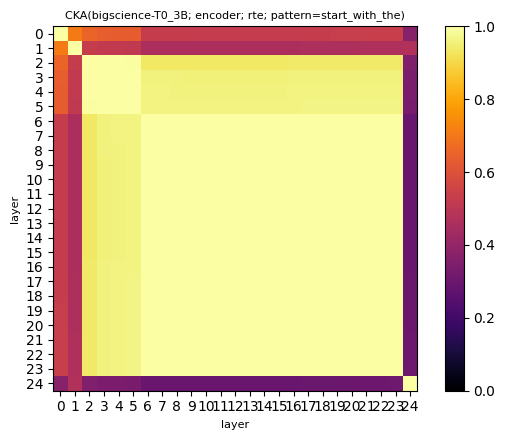

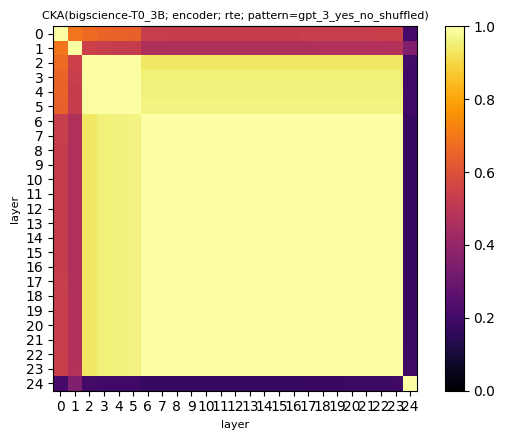

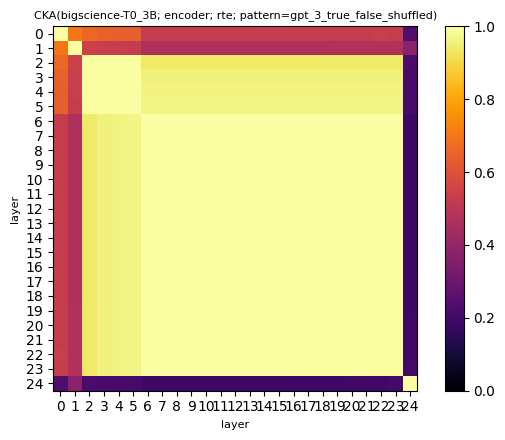

In [14]:
for pattern in list(cka_scores_pattern.keys())[:]:
    values = cka_scores_pattern[pattern]

    fig, axes = plt.subplots(1, 1, figsize=(6.0,4.5), dpi=100)

    im = axes.imshow(values, cmap='inferno', vmin=0.0, vmax=1.0)
    # Create colorbar
    cbar = axes.figure.colorbar(im, ax=axes)
    cbar.ax.set_ylabel("", rotation=-90, va="bottom")

    axes.set_xlabel("layer", fontsize=8)
    axes.set_xticks(np.arange(len(values)))
    axes.set_ylabel("layer", fontsize=8)
    axes.set_yticks(np.arange(len(values)))

    axes.set_title(f"CKA({model}; {module}; {task}; pattern={pattern})", fontsize=8)

    plt.tight_layout()
    plt.show()
    plt.close();


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


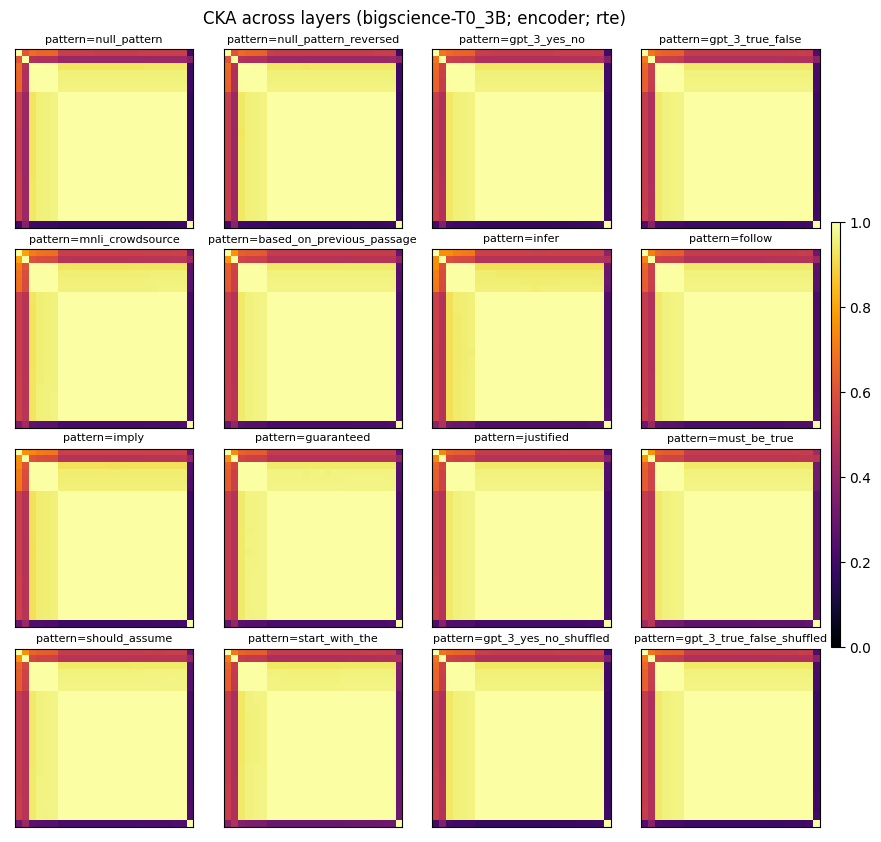

In [27]:
plt.figure(figsize=(8.5, 8.5), dpi=100)

for l, pattern in enumerate(cka_scores_pattern.keys()):
    values = cka_scores_pattern[pattern]

    plt.subplot(4, 4, l+1)
    axes = plt.gca()
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    im = axes.imshow(values, cmap='inferno', vmin=0.0, vmax=1.0)
    # Create colorbar
    # cbar = axes.figure.colorbar(im, ax=axes)
    # cbar.ax.set_ylabel("", rotation=-90, va="bottom")

    axes.set_xlabel("template", fontsize=8)
    axes.set_xticks(np.arange(len(values)))
    axes.set_ylabel("template", fontsize=8)
    axes.set_yticks(np.arange(len(values)))

    # axes.set_title(f"Pairwise CKA ({model}; {module}; {task}; layer={layer})", fontsize=8)
    axes.set_title(f"pattern={pattern}", fontsize=8)

# add colorbar
fig = plt.gcf()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.99, 0.23, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle(f"CKA across layers ({model}; {module}; {task})")
plt.tight_layout()
plt.show()
plt.close();